## 1 Prepare training data

In [118]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

tf.reset_default_graph()

# 下載資料到 mnist_data/ 資料夾下
mnist_data = input_data.read_data_sets('mnist_data', one_hot=True, reshape=False, validation_size=0)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


## 2 Create computal gragh

> y = softmax(weights * x + biases)

In [119]:
x = tf.placeholder(tf.float32, [None, 28, 28, 1], name='input_image')
y = tf.placeholder(tf.float32, [None, 10], name='y')

# 10個神經元 784px image
weights = tf.Variable(tf.zeros([784, 10]), name='weights')
biases = tf.Variable(tf.zeros([10]), name='biases')

In [120]:
flatten_x = tf.reshape(x, [-1, 784], name='flatten_x')
# [784, 10] x [100, 784] ==> Fail
# [100, 784] x [784, 10] ==> [100, 10]
# W x X
wx = tf.matmul(flatten_x, weights, name='wx') # [100, 10]
# WX + biases ==> 答案 v [-1, 10]
final_y = tf.nn.softmax(wx + biases, name='prediction') # [100, 10]

## 3 Loss function

In [121]:
# cross entropy: loss = - sum(Y * log(finalY))
loss = - tf.reduce_mean(y * tf.log(final_y)) * 10 * 100
train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss=loss)


### Extra job for accuracy.

In [122]:
correct_prediction = tf.equal(
    tf.arg_max(final_y, 1),
    tf.arg_max(y, 1)
) # True or False => [100] [T, F, T, F, ....]

accuracy = tf.reduce_mean(
    tf.cast(correct_prediction, tf.float32) # 轉型成float32
)

## 4 Run the session

In [123]:
accuracy_results = []
loss_results = []

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for step in range(2000):
        # Get the training data from file
        batch_x, batch_y = mnist_data.train.next_batch(100)
        session.run(train, feed_dict={
            x: batch_x,
            y: batch_y
        })
        # train 
        accuracy_batch, loss_batch = session.run([accuracy, loss], feed_dict={
            x: batch_x,
            y: batch_y
        })
        # test
        test_x = mnist_data.test.images
        test_y = mnist_data.test.labels
        accuracy_test, loss_test = session.run([accuracy, loss], feed_dict={
            x: test_x,
            y: test_y
        })

        accuracy_results.append({'accuracy_batch': accuracy_batch, 'accuracy_test': accuracy_test})
        loss_results.append({'loss_batch': loss_batch, 'loss_test': loss_test})

In [124]:
%matplotlib inline

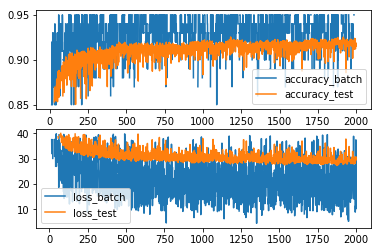

In [125]:
import pandas
import matplotlib.pyplot as plt

pd = pandas.DataFrame(accuracy_results)
pd2 = pandas.DataFrame(loss_results)

pd = pd[(pd > 0.85) & (pd < 0.95)]
pd2 = pd2[pd2 < 40]

fig, axes = plt.subplots(nrows=2, ncols=1)

pd.plot(ax=axes[0])
pd2.plot(ax=axes[1])

## 5 Save

In [126]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    # Saver 必須在session還存在的情況使用
    saver = tf.train.Saver()
    
    for step in range(2000):
        # Get the training data from file
        batch_x, batch_y = mnist_data.train.next_batch(100)
        session.run(train, feed_dict={
            x: batch_x,
            y: batch_y
        })
        # train 
        accuracy_batch, loss_batch = session.run([accuracy, loss], feed_dict={
            x: batch_x,
            y: batch_y
        })
        # test
        test_x = mnist_data.test.images
        test_y = mnist_data.test.labels
        accuracy_test, loss_test = session.run([accuracy, loss], feed_dict={
            x: test_x,
            y: test_y
        })
        
    # save gragh/variables.
    saver.save(session, './save/hand_write.ckpt')

## 6 Restore

In [128]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

tf.reset_default_graph()

# 下載資料到 mnist_data/ 資料夾下
mnist_data = input_data.read_data_sets('mnist_data', one_hot=True, reshape=False, validation_size=0)

x = tf.placeholder(tf.float32, [None, 28, 28, 1], name='input_image')
y = tf.placeholder(tf.float32, [None, 10], name='y')

# 10個神經元 784px image
weights = tf.Variable(tf.zeros([784, 10]), name='weights')
biases = tf.Variable(tf.zeros([10]), name='biases')

flatten_x = tf.reshape(x, [-1, 784], name='flatten_x')
wx = tf.matmul(flatten_x, weights, name='wx') # [100, 10]
final_y = tf.nn.softmax(wx + biases, name='prediction') # [100, 10]

loss = - tf.reduce_mean(y * tf.log(final_y)) * 10 * 100
train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss=loss)

correct_prediction = tf.equal(
    tf.arg_max(final_y, 1),
    tf.arg_max(y, 1)
) # True or False => [100] [T, F, T, F, ....]

accuracy = tf.reduce_mean(
    tf.cast(correct_prediction, tf.float32) # 轉型成float32
)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    # Saver 必須在session還存在的情況使用
    saver = tf.train.Saver()
    
    # Try restore *.ckpt
    exist = tf.train.get_checkpoint_state('./save/')
    
    if exist:
        saver.restore(session, './save/hand_write.ckpt')
        print('Restore ok.')
    else:
        print('No exist checkpoint.')
    
    # for step in range(2000):
        ## Get the training data from file
        # batch_x, batch_y = mnist_data.train.next_batch(100)
        # session.run(train, feed_dict={x: batch_x, y: batch_y})
        ## train 
        # accuracy_batch, loss_batch = session.run([accuracy, loss], feed_dict={x: batch_x, y: batch_y})
        ## test
        # test_x = mnist_data.test.images
        # test_y = mnist_data.test.labels
        # accuracy_test, loss_test = session.run([accuracy, loss], feed_dict={x: test_x, y: test_y})

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from ./save/hand_write.ckpt
Restore ok.
